# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [5]:
from utils import get_dataset, int64_feature, int64_list_feature, bytes_feature, bytes_list_feature, float_list_feature
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow.compat.v1 as tf
import os
from matplotlib.lines import Line2D
import io
import IPython.display as display
from PIL import Image
from waymo_open_dataset import dataset_pb2 as open_dataset
%matplotlib inline

In [6]:
path_tfrecord= os.path.join(os.getcwd(),'data','train/') #"/home/workspace/data/train/"
dataset_tf = get_dataset(f"{path_tfrecord}*.tfrecord",)

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [7]:
    # display dataset specs
print('#########################################TFrecord Information#########################################')
print(dataset_tf.element_spec)
    
    ### create batch for display
    # batch size
global num_images
num_images = 10
    # Number of filenames to read in shuffle
num_files = len([entry for entry in os.listdir(path_tfrecord) if os.path.isfile(os.path.join(path_tfrecord, entry))]) #86
   #Select random tfrecord files
batch_tf = dataset_tf.shuffle(num_files, reshuffle_each_iteration=True).take(num_images)
    
    # display image size 
print('#################Image Size#################')
for record in batch_tf:
        print(record["original_image_spatial_shape"].numpy())
     # bboxes in format [0...1] - rescale to image size
print('#################GrndTruth BBX#################')
for record in batch_tf:
        print(record["groundtruth_boxes"].numpy())
    

#########################################TFrecord Information#########################################
{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'key': TensorSpec(shape=(), dtype=tf.string, name=None), 'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bo

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [10]:
def display_images(batch):
    # color map classes
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    # matching legend lines
    legend_lines = [Line2D([0], [0], color=colormap[1], lw=1, label="vehicles"), 
                    Line2D([0], [0], color=colormap[2], lw=1, label="pedestrians"), 
                    Line2D([0], [0], color=colormap[4], lw=1, label="bicycles")]
    
    # number of rows in plot
    num_rows = 2
    
    # define rows/cols in figure
    if num_images % num_rows == 0:
        num_cols = num_images // num_rows
    else:
        num_cols = num_images % num_rows + 1
        
    # set up figure
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle('Explore GroundTruth Data')
    
        ### for each tfrecord in batch...
    for idx, record in enumerate(batch):

        # getting specs
        img = record["image"].numpy()
        img_shape = record["original_image_spatial_shape"].numpy()
        filename = record["filename"]
        bboxes = record["groundtruth_boxes"].numpy()
        classes = record["groundtruth_classes"].numpy()

        # getting image and put in background
        curr_row = idx % num_rows
        curr_col = idx % num_cols
        axs[curr_row, curr_col].imshow(img)

        # adding bounding boxes to the foregound
        for box, cl in zip(bboxes, classes):
            # get box coordinates
            y1, x1, y2, x2 = box
            # rescale to image size
            x1, x2 = img_shape[0]*x1, img_shape[0]*x2
            y1, y2 = img_shape[1]*y1, img_shape[1]*y2
            # define rectangle and color with colormap
            rec = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor=colormap[cl])
            # add rectangle to plot
            axs[curr_row, curr_col].add_patch(rec)
            
    # adding legend and adjust layout
    axs[num_rows-1,0].legend(handles=legend_lines, loc='center', bbox_to_anchor=(0,-0.2))
    plt.tight_layout()
    plt.show()

    # save figure to png
    fig.savefig('Results_Negin/data_exploratory_analysis.png')
    pass

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

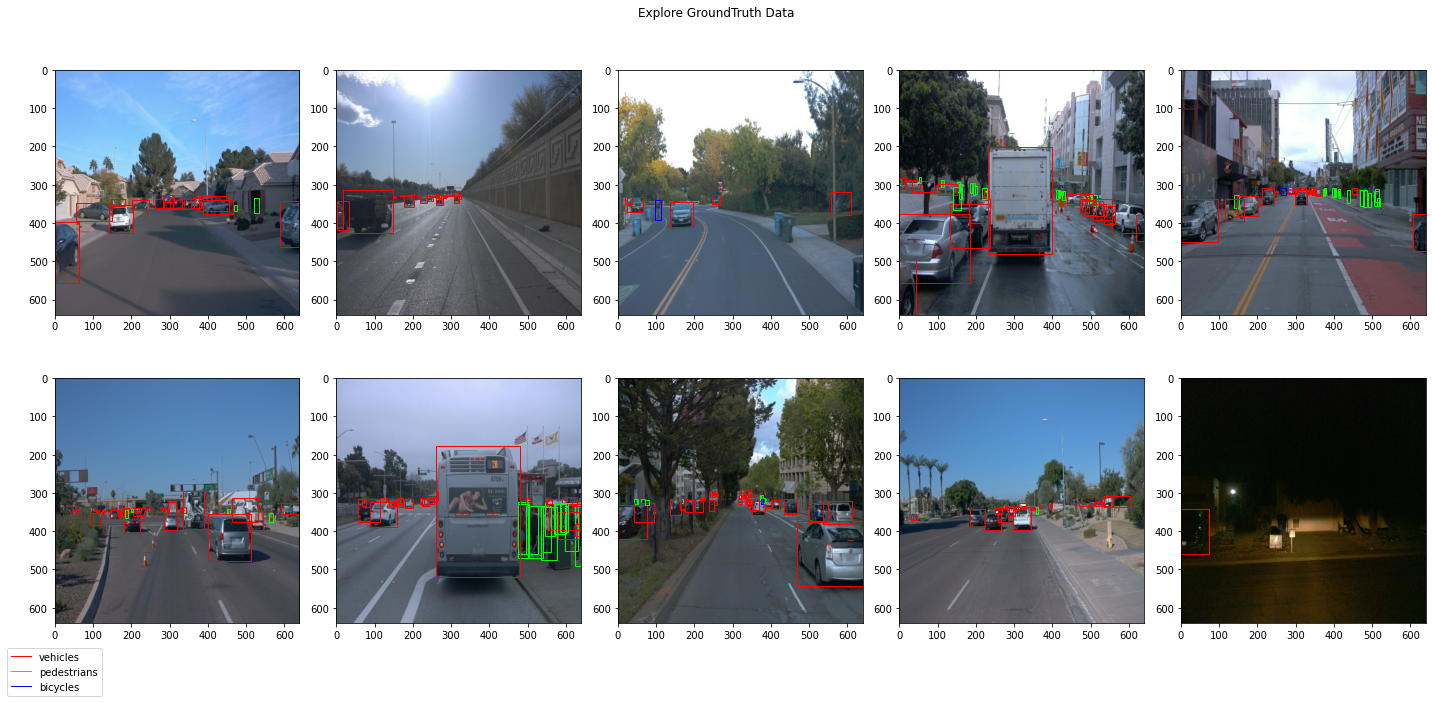

#########################################STEP1 (EDA)- Image/BBX Display Completed for the Batch#########################################


In [15]:
# Display 10 random images in dataset
# STEP1(EDA)- Display random images from train dataset: num_images
display_images(batch_tf)
print('#########################################STEP1 (EDA)- Image/BBX Display Completed for the Batch#########################################')
    

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Distribution of Classes (Vehicle, Pedestrian, Cycles)
In this section, 1000 data are analyzed to understand class (vehicle, pedestrian, cycles) distribution:

In [12]:
class_count = {1: 0, 2: 0, 4: 0}
pixel_values_mean = []
data_count=0

for idx, train_data in enumerate(dataset_tf):
    image = train_data['image'].numpy()
    classes = train_data['groundtruth_classes'].numpy()
 
    for obj_class in classes:
        class_count[obj_class] += 1

    # mean pixel value of each image
    pixel_values_mean.append(np.mean(image))
    
    data_count += 1
    if data_count == 10000:
        break

print(f'Total number of data being analyzed: {data_count}')

Total number of images being analyzed: 10000


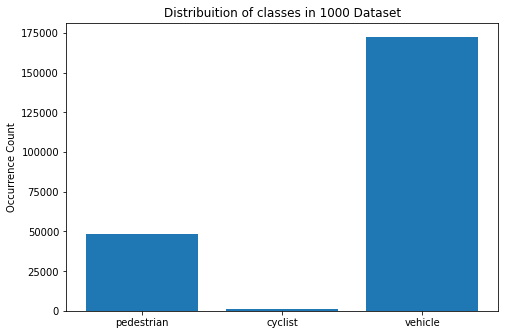

In [13]:
number_of_vehicles = class_count[1]
number_of_pedestrians = class_count[2]
number_of_cyclists = class_count[4]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

ax.set_title('Distribuition of classes in 1000 Dataset')
ax.set_ylabel('Occurrence Count')

labels = ['pedestrian', 'cyclist', 'vehicle']
values = [number_of_pedestrians, number_of_cyclists, number_of_vehicles]
ax.bar(labels, values)
plt.show()

### Distribution of Mean Pixel Values

Text(0, 0.5, 'Frequeny')

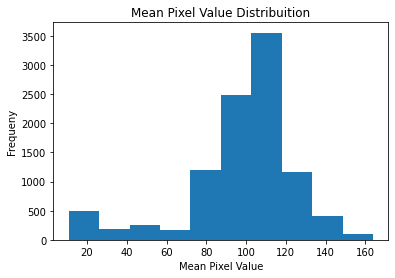

In [14]:
plt.hist(pixel_values_mean)
plt.title('Mean Pixel Value Distribuition')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequeny')